In [3]:
import os
path_to_folder = "/dlabscratch1/baldwin/pause2/PauseToken/logs/train/runs/2024-11-04_16-38-59/"
model_path = os.path.join(path_to_folder, "last_ckpt")
path_to_test_res = "/dlabscratch1/baldwin/pause2/PauseToken/logs/train/runs/2024-11-05_08-30-36/test_results.json" #os.path.join(path_to_folder, "test_results.json")
path_to_gt = "/dlabscratch1/baldwin/pause2/PauseToken/data/gsm8k_json/gsm8k/test.json"

In [4]:
from src.model.components.control_token_wrappers.pause_wrapper import PauseClassifierWrapper
from transformers import AutoTokenizer
model = PauseClassifierWrapper.from_pretrained(model_path, device_map="cpu")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]/dlabscratch1/baldwin/miniconda3/envs/lm_stable_baselines/lib/python3.11/site-packages/torch/nn/modules/module.py:2068: UserWarning: for model.embed_tokens.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/dlabscratch1/baldwin/miniconda3/envs/lm_stable_baselines/lib/python3.11/site-packages/torch/nn/modules/module.py:2068: UserWarning: for model.layers.0.self_attn.q_proj.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead o

Setting control token temperature to 1.0


Loading checkpoint shards: 100%|██████████| 3/3 [00:20<00:00,  6.78s/it]


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PauseClassifierWrapper(
      (language_model): MistralForCausalLM(
        (model): MistralModel(
          (embed_tokens): ExtendedEmbedding(
            (original_embedding): Embedding(32000, 4096)
            (new_embedding): ModulesToSaveWrapper(
              (original_module): Embedding(1, 4096)
              (modules_to_save): ModuleDict(
                (default): Embedding(1, 4096)
              )
            )
          )
          (layers): ModuleList(
            (0-31): 32 x MistralDecoderLayer(
              (self_attn): MistralSdpaAttention(
                (q_proj): lora.Linear(
                  (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=4096, out_features=16, bias=F

In [5]:
pause_embedding = model.language_model.get_input_embeddings().new_embedding.weight

lm_embeddings = model.language_model.get_input_embeddings().original_embedding.weight

In [6]:
import torch

#compute the cosine similarity between the pause embeddings and the original embeddings
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
similarity = cos(pause_embedding, lm_embeddings)
#compute the l2 norm of the difference between the pause embeddings and the original embeddings
l2 = torch.nn.PairwiseDistance(p=2)
l2_norm = l2(pause_embedding, lm_embeddings)

similarity.shape, l2_norm.shape

(torch.Size([32000]), torch.Size([32000]))

In [7]:
k = 10
#find indices of the top 10 most similar embeddings
top_k_cos = torch.argsort(similarity, descending=True)[:k]
top_k_l2 = torch.argsort(l2_norm, descending=False)[:k]
top_k_cos_least = torch.argsort(similarity, descending=False)[:k]
top_k_l2_least = torch.argsort(l2_norm, descending=True)[:k]
from prettytable import PrettyTable

t_cos = PrettyTable(["rank", "token_id", "token", "cosine similarity"])

for i, idx in enumerate(top_k_cos):
    t_cos.add_row([i+1, idx.item(), repr(tokenizer.convert_ids_to_tokens(idx.item())), round(similarity[idx].item(),5)])

t_l2 = PrettyTable(["rank", "token_id", "token", "l2 norm"])
for i, idx in enumerate(top_k_l2):
    t_l2.add_row([i+1, idx.item(), repr(tokenizer.convert_ids_to_tokens(idx.item())), round(l2_norm[idx].item(),5)])
    
t_cos_least = PrettyTable(["rank", "token_id", "token", "cosine similarity"])

for i, idx in enumerate(top_k_cos_least):
    t_cos_least.add_row([i+1, idx.item(), repr(tokenizer.convert_ids_to_tokens(idx.item())), round(similarity[idx].item(),5)])
    
t_l2_least = PrettyTable(["rank", "token_id", "token", "l2 norm"])
for i, idx in enumerate(top_k_l2_least):
    t_l2_least.add_row([i+1, idx.item(), repr(tokenizer.convert_ids_to_tokens(idx.item())), round(l2_norm[idx].item(),5)])

In [8]:
print("Top 10 most similar embeddings by cosine similarity")
print(t_cos)

Top 10 most similar embeddings by cosine similarity
+------+----------+--------+-------------------+
| rank | token_id | token  | cosine similarity |
+------+----------+--------+-------------------+
|  1   |  28705   |  '▁'   |      0.08719      |
|  2   |  28756   |  '\\'  |       0.0782      |
|  3   |  28730   |  '_'   |      0.07281      |
|  4   |  28733   |  '-'   |       0.0657      |
|  5   |  14695   | '▁\\;' |      0.06552      |
|  6   |   387    |  '▁-'  |      0.06256      |
|  7   |  13958   |  '^^'  |      0.06112      |
|  8   |   1047   | '▁If'  |      0.06103      |
|  9   |  20608   | 'intr' |      0.06028      |
|  10  |  14076   | '($_'  |      0.05996      |
+------+----------+--------+-------------------+


In [9]:
print("Top 10 most similar embeddings by l2 norm")
print(str(t_l2))

Top 10 most similar embeddings by l2 norm
+------+----------+----------+---------+
| rank | token_id |  token   | l2 norm |
+------+----------+----------+---------+
|  1   |   9823   |  '*/\r'  | 0.19286 |
|  2   |   7608   | '▁*/\r'  | 0.19293 |
|  3   |  14756   | '/**\r'  | 0.19296 |
|  4   |  26407   |  '};\r'  |  0.193  |
|  5   |  18759   |  "';\r"  | 0.19301 |
|  6   |  10278   |  "',\r"  | 0.19302 |
|  7   |  26083   | '▁//\r'  | 0.19302 |
|  8   |   101    | '<0x62>' | 0.19305 |
|  9   |    94    | '<0x5B>' | 0.19305 |
|  10  |    95    | '<0x5C>' | 0.19305 |
+------+----------+----------+---------+


In [10]:
print("Top 10 least similar embeddings by cosine similarity")
print(t_cos_least)

Top 10 least similar embeddings by cosine similarity
+------+----------+-------------+-------------------+
| rank | token_id |    token    | cosine similarity |
+------+----------+-------------+-------------------+
|  1   |   2761   |    '▁cir'   |       -0.066      |
|  2   |  14834   |   '▁crate'  |      -0.06182     |
|  3   |   4527   |  '▁October' |      -0.0615      |
|  4   |   9696   | '▁numerous' |      -0.06098     |
|  5   |   3410   |    'aves'   |      -0.06073     |
|  6   |  27583   |   'ippet'   |      -0.05962     |
|  7   |   9287   |  'ABILITY'  |      -0.05935     |
|  8   |  14734   |    'uego'   |      -0.05873     |
|  9   |  12903   | '▁informed' |      -0.05848     |
|  10  |  28467   |  '▁membre'  |      -0.05814     |
+------+----------+-------------+-------------------+


In [11]:
print("Top 10 least similar embeddings by l2 norm")
print(str(t_l2_least))

Top 10 least similar embeddings by l2 norm
+------+----------+------------------+---------+
| rank | token_id |      token       | l2 norm |
+------+----------+------------------+---------+
|  1   |   1566   |       'ww'       | 0.31986 |
|  2   |  12645   |    '▁släktet'    | 0.30467 |
|  3   |  31491   |       '￼'        | 0.30234 |
|  4   |  13129   |    '▁listade'    | 0.30088 |
|  5   |  29985   |       '😭'       |   0.3   |
|  6   |  30464   |       '😊'       | 0.29861 |
|  7   |  29196   |       '😂'       | 0.29654 |
|  8   |  18522   |   '▁forehead'    |  0.2956 |
|  9   |  22897   |  'appendChild'   | 0.29423 |
|  10  |  24744   | 'preventDefault' | 0.29412 |
+------+----------+------------------+---------+


In [12]:
import json

with open(path_to_test_res, "r") as f:
    test_res = json.load(f)
with open(path_to_gt, "r") as f:
    gt = json.load(f)

In [13]:
import numpy as np
accuracy = np.mean(list(map(lambda x: x["test/accuracy"], test_res)))
accuracy

0.645185746777862

In [14]:
test_res[0].keys()

dict_keys(['generated_text', 'tokenized_text', 'input', 'predicted_output', 'ground_truth', 'test/accuracy'])

In [15]:
for res in test_res:
    n_pauses = res["generated_text"].count("<|pause|>")
    res["n_pauses"] = n_pauses

In [28]:
#make a plot of number of pauses vs accuracy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(test_res)
df_acc = df.groupby("n_pauses")["test/accuracy"].mean().reset_index()
df_size = df.groupby("n_pauses").size().reset_index().rename(columns={0: "size"})
#merge the two dataframes
merged_df = pd.merge(df_acc, df_size, on="n_pauses")
display(merged_df)


,n_pauses,test/accuracy,size
0,0,0.678526,787
1,1,0.631148,244
2,2,0.530120,83
3,3,0.600000,40
4,4,0.450000,20
...,...,...,...
56,116,0.000000,1
57,124,0.000000,1
58,129,0.000000,1
59,130,1.000000,1


In [31]:
df

,generated_text,tokenized_text,input,predicted_output,ground_truth,test/accuracy,n_pauses
0,<s> ### INPUT: Janet’s ducks lay 16 eggs per d...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Janet’s ducks lay 16 eggs per day. She eats th...,Janet eats 3 eggs for breakfast and bakes 4 eg...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,True,0
1,<s> ### INPUT: A robe takes 2 bolts of blue fi...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",A robe takes 2 bolts of blue fiber and half th...,It takes 2*1/2=<<2*1/2=1>>1 bolt of white fibe...,It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...,True,0
2,<s> ### INPUT: Josh decides to try flipping a ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Josh decides to try flipping a house. He buys...,The house<|pause|> is<|pause|> worth 80000*1.5...,The cost of the house and repairs came out to ...,False,2
3,<s> ### INPUT: James decides to run 3 sprints ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",James decides to run 3 sprints 3 times a week....,He runs 3*3=<<3*3=9>>9 sprints a week\nSo he r...,He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...,True,0
4,"<s> ### INPUT: Every day, Wendi feeds each of ...","[1, 774, 2693, 9838, 28747, 4203, 1370, 28725,...","Every day, Wendi feeds each of her chickens th...","In the morning, Wendi gives her chickens 15 cu...","If each chicken eats 3 cups of feed per day, t...",True,0
...,...,...,...,...,...,...,...
1314,<s> ### INPUT: John had a son James when he wa...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",John had a son James when he was 19. James is...,James is<|pause|> currently twice as old as Do...,Dora is 12-3=<<12-3=9>>9\nSo James is 9*2=<<9*...,False,8
1315,<s> ### INPUT: There are some oranges in a bas...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",There are some oranges in a basket. Ana spends...,"If Ana spends 3 minutes peeling an orange, she...",There are 60 minutes in an hour. Ana peels an ...,True,0
1316,<s> ### INPUT: Mark's car breaks down and he n...,"[1, 774, 2693, 9838, 28747, 3655, 28742, 28713...",Mark's car breaks down and he needs to get a n...,The radiator<|pause|> was $400 and he got it f...,The discount on the radiator was 400*.8=$<<400...,False,1
1317,<s> ### INPUT: Farmer Brown has 20 animals on ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Farmer Brown has 20 animals on his farm, all e...",First find the average number of legs per anim...,Let C be the number of chickens.\nThere are 20...,False,0


In [29]:
merged_df["size"]/merged_df["size"].sum()

0     0.596664
1     0.184989
2     0.062926
3     0.030326
4     0.015163
        ...   
56    0.000758
57    0.000758
58    0.000758
59    0.000758
60    0.000758
Name: size, Length: 61, dtype: float64

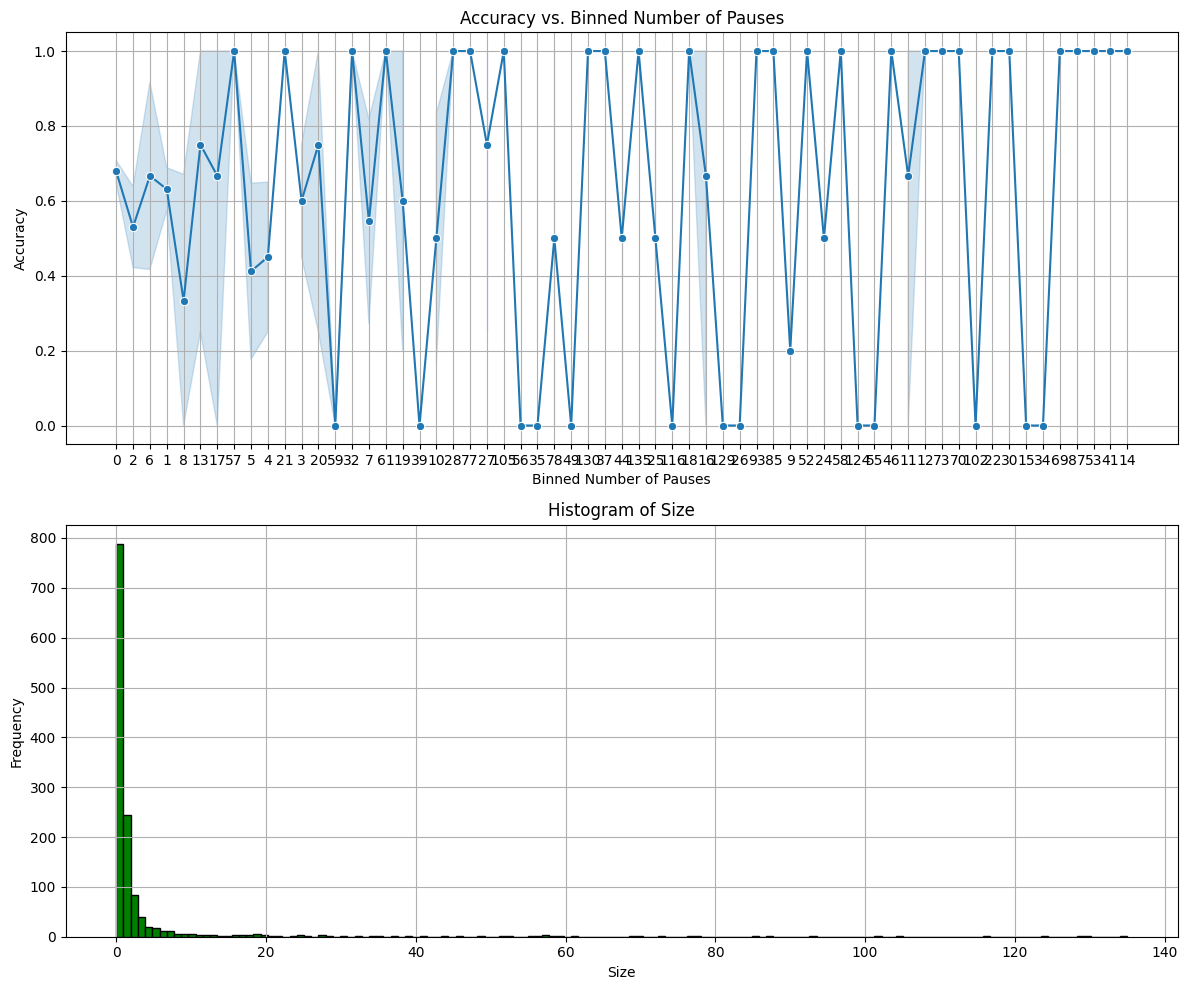

In [32]:
# Define bins for n_pauses
# bins = np.linspace(merged_df['n_pauses'].min(), merged_df['n_pauses'].max(), num=50)
# merged_df['n_pauses'] = pd.cut(merged_df['n_pauses'], bins=bins)

# Group by the binned n_pauses and calculate the mean accuracy
binned_df = merged_df

# Create a figure with two subplots
fig, ax1 = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Accuracy vs Binned Number of Pauses
sns.lineplot(ax=ax1[0], x=df['n_pauses'].astype(str), y='test/accuracy', data=df, marker='o')
ax1[0].set_title('Accuracy vs. Binned Number of Pauses')
ax1[0].set_xlabel('Binned Number of Pauses')
ax1[0].set_ylabel('Accuracy')
ax1[0].grid(True)

# Plot 2: Histogram of Size
ax1[1].hist(df['n_pauses'], bins=140, color='green', edgecolor='black')
ax1[1].set_title('Histogram of Size')
ax1[1].set_xlabel('Size')
ax1[1].set_ylabel('Frequency')
ax1[1].grid(True)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()

In [27]:
binned_df['n_pauses']

0                    NaN
1           (0.0, 2.755]
2           (0.0, 2.755]
3          (2.755, 5.51]
4          (2.755, 5.51]
             ...        
56    (115.714, 118.469]
57     (123.98, 126.735]
58     (126.735, 129.49]
59     (129.49, 132.245]
60      (132.245, 135.0]
Name: n_pauses, Length: 61, dtype: category
Categories (49, interval[float64, right]): [(0.0, 2.755] < (2.755, 5.51] < (5.51, 8.265] < (8.265, 11.02] ... (123.98, 126.735] < (126.735, 129.49] < (129.49, 132.245] < (132.245, 135.0]]

In [22]:
merged_df.head(20)

,n_pauses,test/accuracy,size,n_pauses_binned
0,0,0.678526,787,NaN
1,1,0.631148,244,"(0.0, 2.755]"
2,2,0.530120,83,"(0.0, 2.755]"
3,3,0.600000,40,"(2.755, 5.51]"
4,4,0.450000,20,"(2.755, 5.51]"
5,5,0.411765,17,"(2.755, 5.51]"
6,6,0.666667,12,"(5.51, 8.265]"
7,7,0.545455,11,"(5.51, 8.265]"
8,8,0.333333,6,"(5.51, 8.265]"
9,9,0.200000,5,"(8.265, 11.02]"


In [72]:
merged_df["size"]/merged_df["size"].sum()

0      0.322972
1      0.122820
2      0.079606
3      0.051554
4      0.034875
         ...   
128    0.000758
129    0.000758
130    0.000758
131    0.000758
132    0.000758
Name: size, Length: 133, dtype: float64